In [17]:
# Cell 1: Import Libraries and Setup
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory
output_dir = Path('visualizations')
output_dir.mkdir(exist_ok=True)

print("Setup complete! Output directory:", output_dir)

Setup complete! Output directory: visualizations


In [18]:
# Cell 2: Load and Explore Results
def load_json_results(file_path):
    """Load results from JSON file"""
    with open(file_path, 'r') as f:
        return json.load(f)

# Load your evaluation results
results_path = '../results/result.json'
results = load_json_results(results_path)

# Display structure
print("Results structure:")
for key in results.keys():
    print(f"- {key}")
    if isinstance(results[key], dict):
        for subkey in results[key].keys():
            print(f"  - {subkey}")

Results structure:
- experiment_info
  - timestamp
  - dataset
  - total_users
  - total_items
  - test_size
  - emotion_model
- retrieval_results
  - Factorization
  - content-based
  - UserCF
  - KNN
  - hybrid
- ranking_results
  - LightGBM
- emotion_analysis
  - emotion_distribution
  - emotion_impact
- diversity_metrics
  - Factorization
  - Swing
  - UserKNN
  - Ensemble


In [19]:
# Cell 3: Experiment Info Summary
print("=" * 50)
print("EXPERIMENT SUMMARY")
print("=" * 50)
for key, value in results['experiment_info'].items():
    print(f"{key}: {value}")

EXPERIMENT SUMMARY
timestamp: 2024-01-15T10:30:00
dataset: amazon_books
total_users: 10000
total_items: 50000
test_size: 0.2
emotion_model: j-hartmann/emotion-english-distilroberta-base


In [20]:
# Cell 4: Retrieval Results Visualization
# Prepare data for retrieval results
retrieval_data = []
for model_name, model_info in results['retrieval_results'].items():
    for metric_name, metric_values in model_info['metrics'].items():
        for k, value in metric_values.items():
            retrieval_data.append({
                'Model': model_name,
                'Metric': metric_name,
                'K': int(k),
                'Value': value
            })

df_retrieval = pd.DataFrame(retrieval_data)

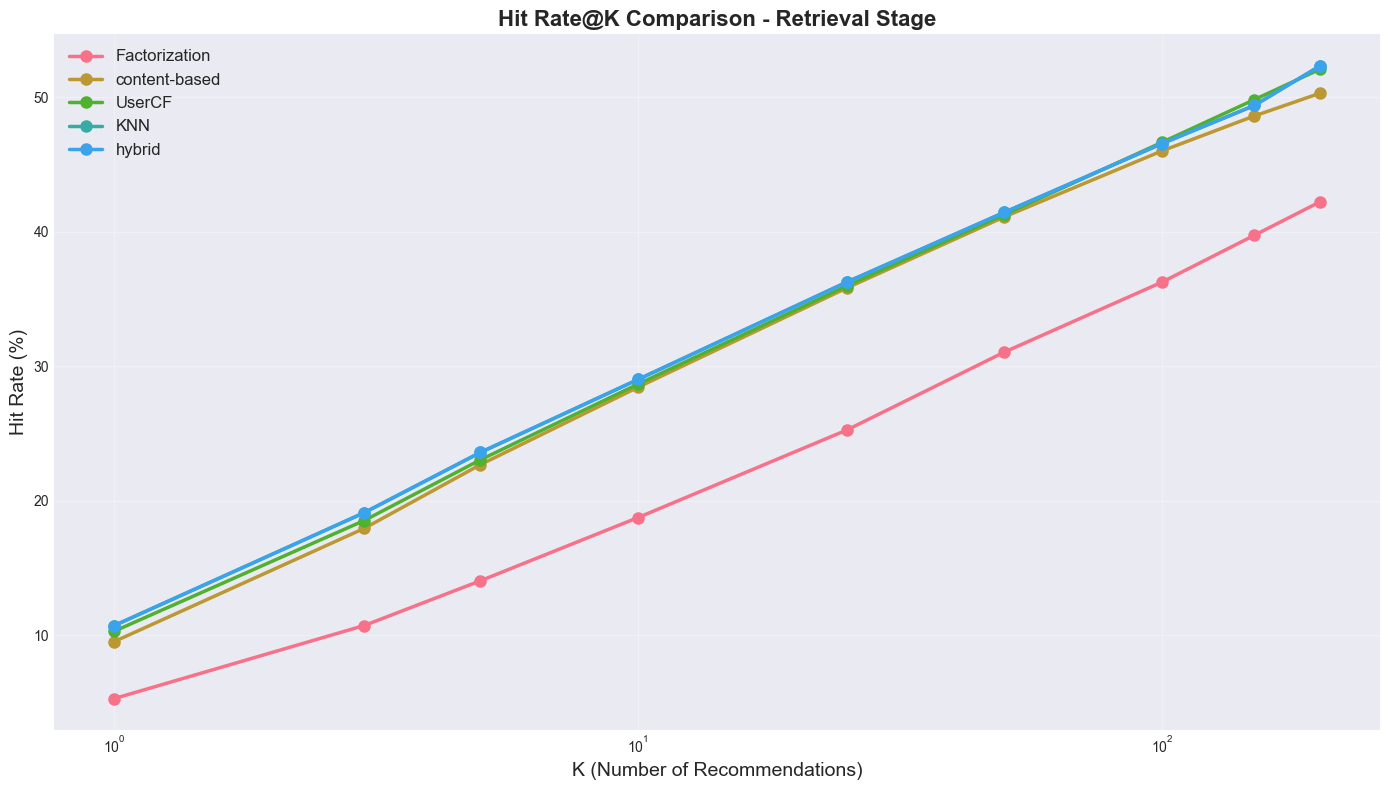

In [21]:
# Plot Hit Rate Comparison
plt.figure(figsize=(14, 8))
for model in df_retrieval['Model'].unique():
    model_data = df_retrieval[(df_retrieval['Model'] == model) & 
                              (df_retrieval['Metric'] == 'hit_rate')]
    plt.plot(model_data['K'], model_data['Value'], 
             marker='o', linewidth=2.5, markersize=8, label=model)

plt.xlabel('K (Number of Recommendations)', fontsize=14)
plt.ylabel('Hit Rate (%)', fontsize=14)
plt.title('Hit Rate@K Comparison - Retrieval Stage', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.tight_layout()
plt.savefig(output_dir / 'retrieval_hit_rate.png', dpi=300)
plt.show()

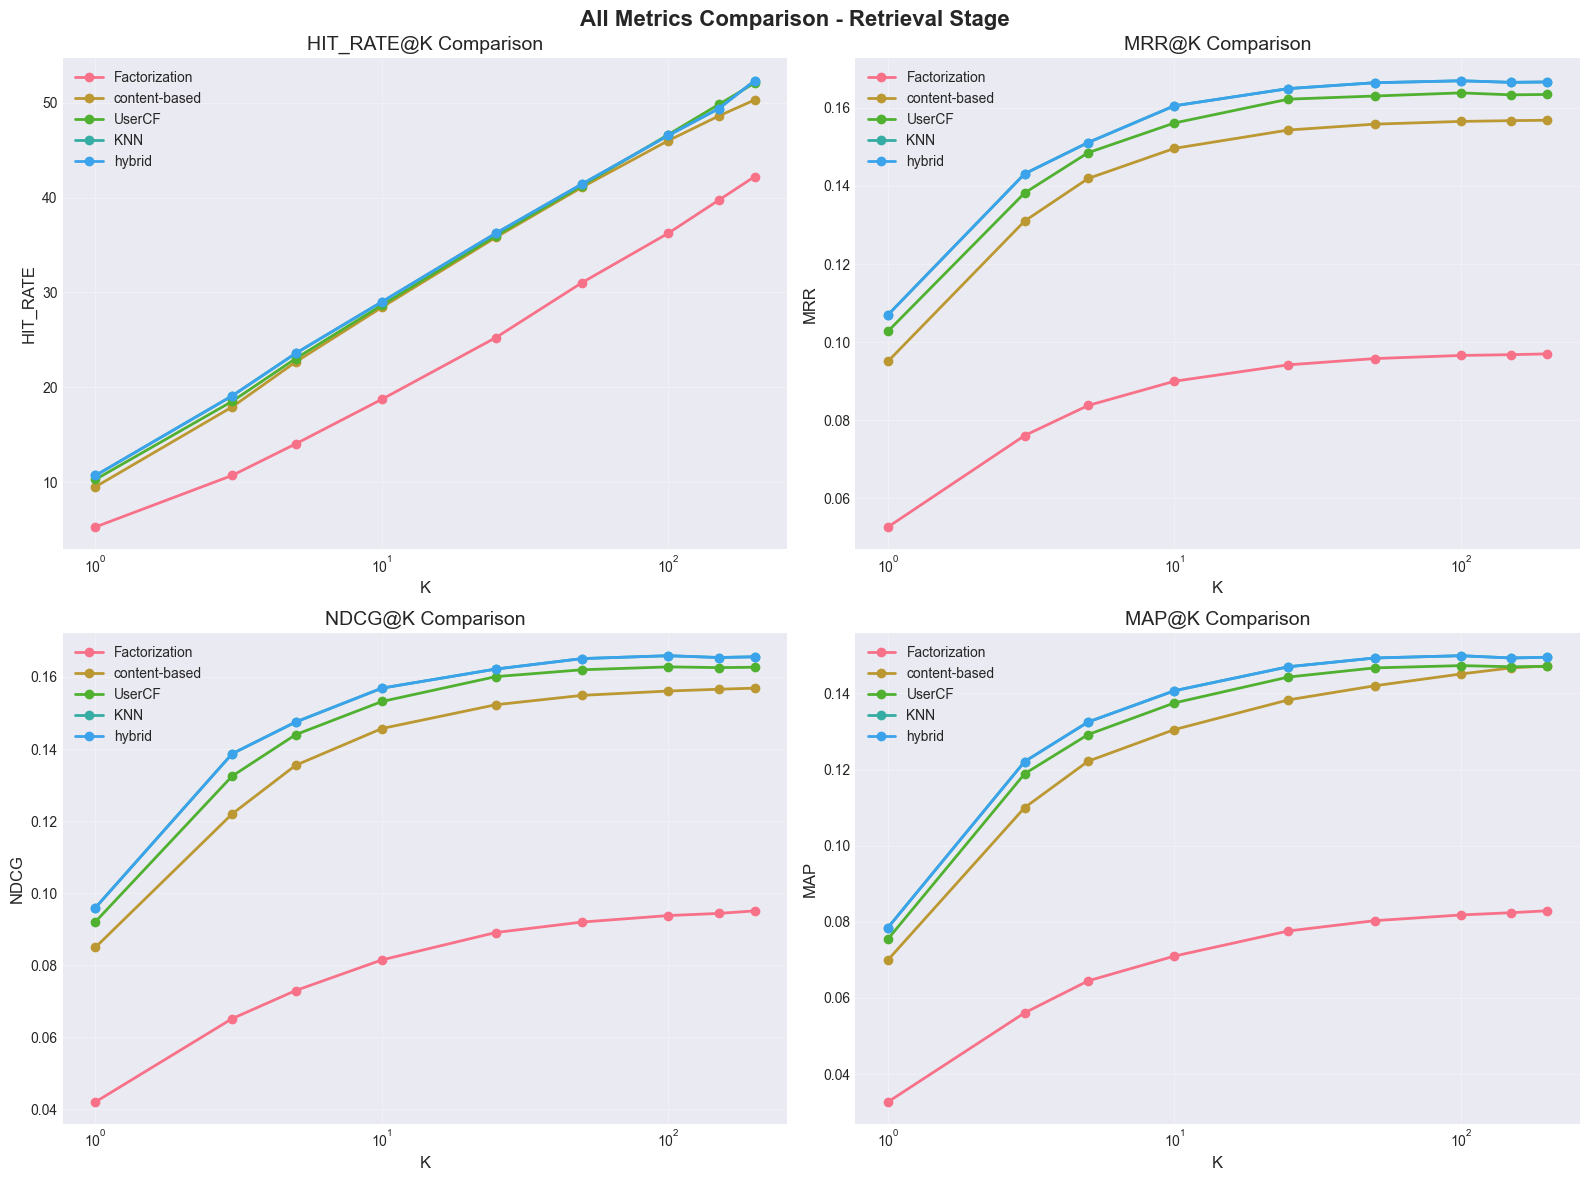

In [22]:
# Cell 5: All Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['hit_rate', 'mrr', 'ndcg', 'map']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    for model in df_retrieval['Model'].unique():
        model_data = df_retrieval[(df_retrieval['Model'] == model) & 
                                  (df_retrieval['Metric'] == metric)]
        ax.plot(model_data['K'], model_data['Value'], 
                marker='o', linewidth=2, label=model)
    
    ax.set_xlabel('K', fontsize=12)
    ax.set_ylabel(metric.upper(), fontsize=12)
    ax.set_title(f'{metric.upper()}@K Comparison', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')

plt.suptitle('All Metrics Comparison - Retrieval Stage', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'all_metrics_comparison.png', dpi=300)
plt.show()


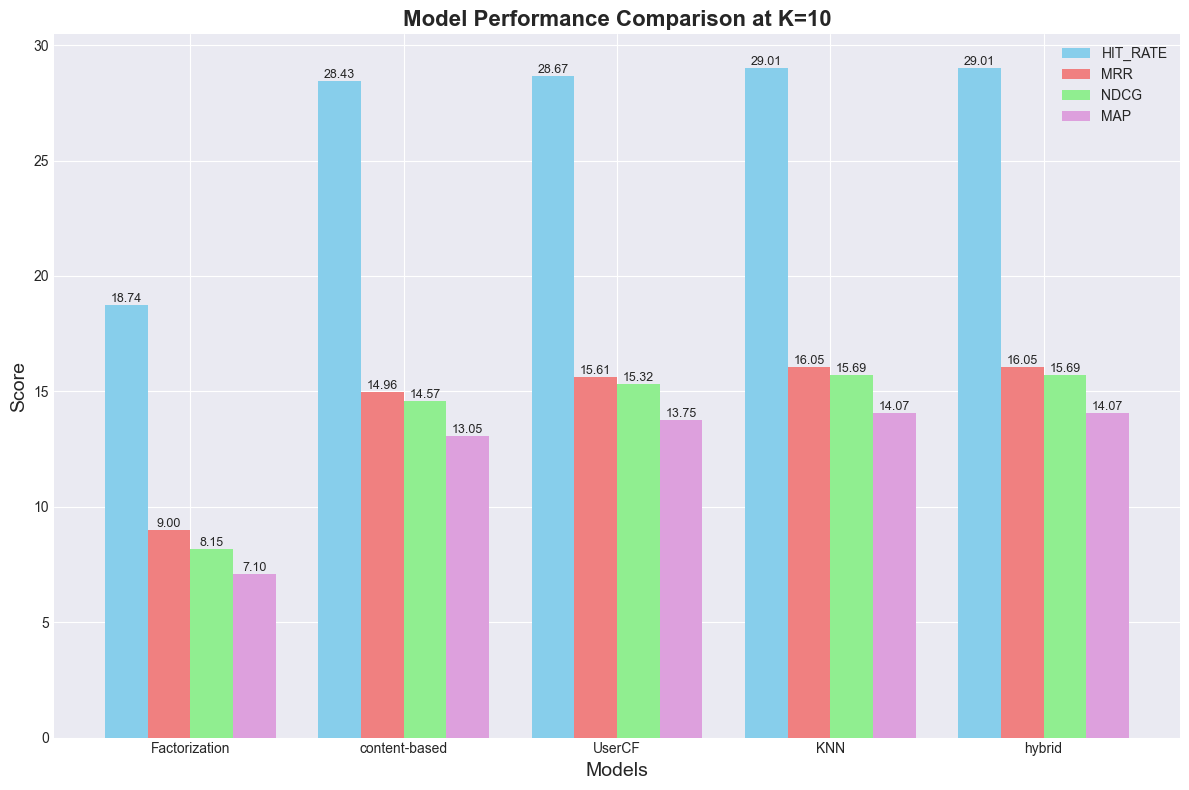

In [23]:
# Cell 6: Model Performance Summary at K=10
k_value = 10
summary_data = []

for model_name, model_info in results['retrieval_results'].items():
    row = {'Model': model_name}
    for metric_name, metric_values in model_info['metrics'].items():
        if str(k_value) in metric_values:
            row[metric_name.upper()] = metric_values[str(k_value)]
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(summary_df))
width = 0.2

metrics_to_plot = ['HIT_RATE', 'MRR', 'NDCG', 'MAP']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum']

for i, metric in enumerate(metrics_to_plot):
    if metric == 'HIT_RATE':
        values = summary_df[metric]
    else:
        values = summary_df[metric] * 100  # Scale for visibility
    
    bars = ax.bar(x + i*width, values, width, label=metric, color=colors[i])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title(f'Model Performance Comparison at K={k_value}', fontsize=16, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(summary_df['Model'])
ax.legend()
plt.tight_layout()
plt.savefig(output_dir / f'model_comparison_k{k_value}.png', dpi=300)
plt.show()

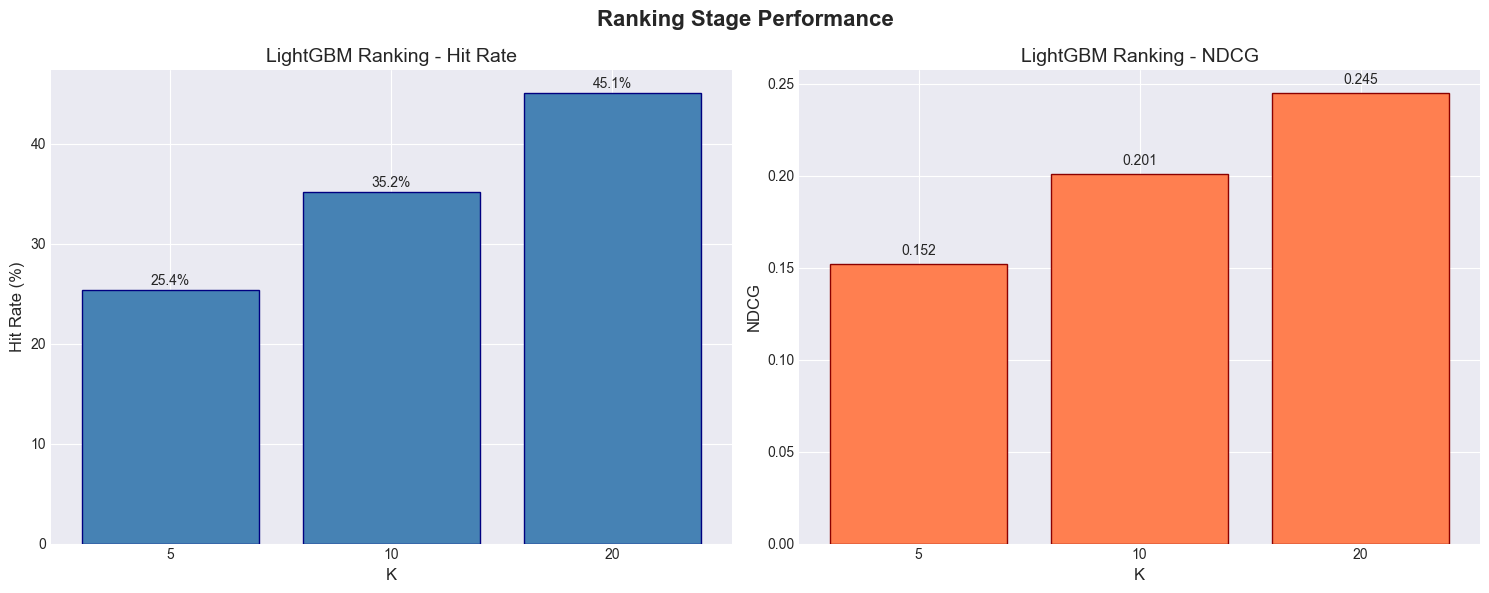

In [24]:
# Cell 7: Ranking Results Visualization
if 'ranking_results' in results:
    ranking_data = results['ranking_results']['LightGBM']
    
    # Plot ranking metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Hit Rate
    k_values = list(ranking_data['metrics']['hit_rate'].keys())
    hit_rates = list(ranking_data['metrics']['hit_rate'].values())
    ax1.bar(k_values, hit_rates, color='steelblue', edgecolor='navy')
    ax1.set_xlabel('K', fontsize=12)
    ax1.set_ylabel('Hit Rate (%)', fontsize=12)
    ax1.set_title('LightGBM Ranking - Hit Rate', fontsize=14)
    for i, v in enumerate(hit_rates):
        ax1.text(i, v + 0.5, f'{v:.1f}%', ha='center')
    
    # NDCG
    ndcg_values = list(ranking_data['metrics']['ndcg'].values())
    ax2.bar(k_values, ndcg_values, color='coral', edgecolor='darkred')
    ax2.set_xlabel('K', fontsize=12)
    ax2.set_ylabel('NDCG', fontsize=12)
    ax2.set_title('LightGBM Ranking - NDCG', fontsize=14)
    for i, v in enumerate(ndcg_values):
        ax2.text(i, v + 0.005, f'{v:.3f}', ha='center')
    
    plt.suptitle('Ranking Stage Performance', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_dir / 'ranking_performance.png', dpi=300)
    plt.show()

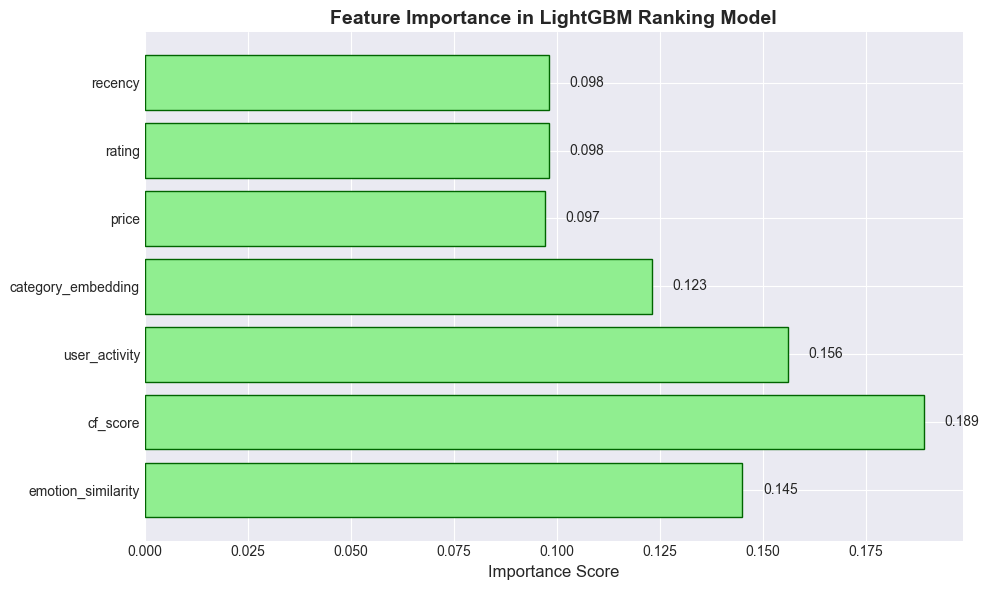

In [25]:
# Cell 8: Feature Importance
if 'feature_importance' in results['ranking_results']['LightGBM']:
    features = list(results['ranking_results']['LightGBM']['feature_importance'].keys())
    importance = list(results['ranking_results']['LightGBM']['feature_importance'].values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(features, importance, color='lightgreen', edgecolor='darkgreen')
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Feature Importance in LightGBM Ranking Model', fontsize=14, fontweight='bold')
    
    # Add value labels
    for bar, val in zip(bars, importance):
        plt.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', va='center')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'feature_importance.png', dpi=300)
    plt.show()

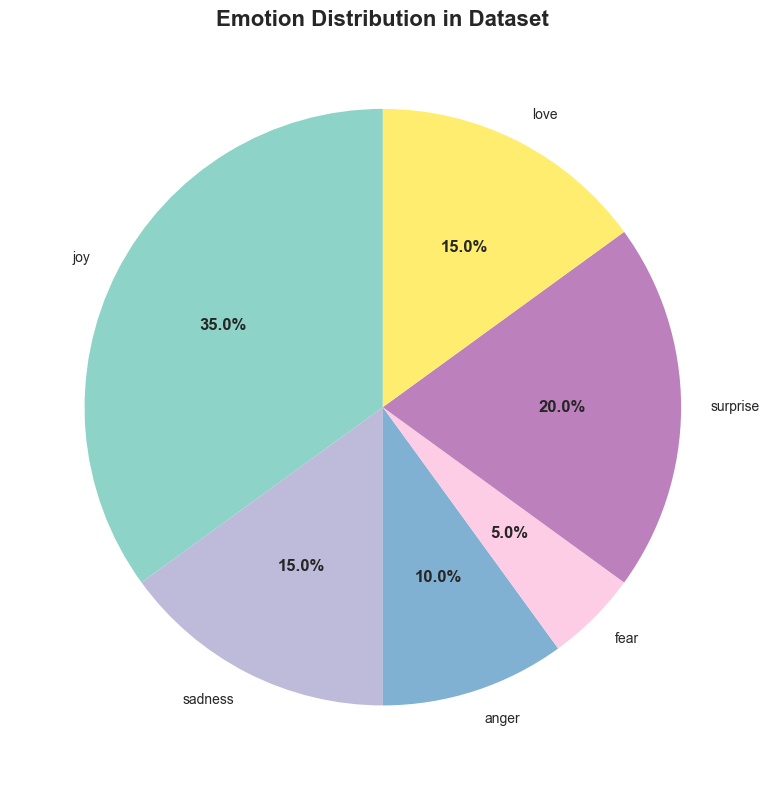

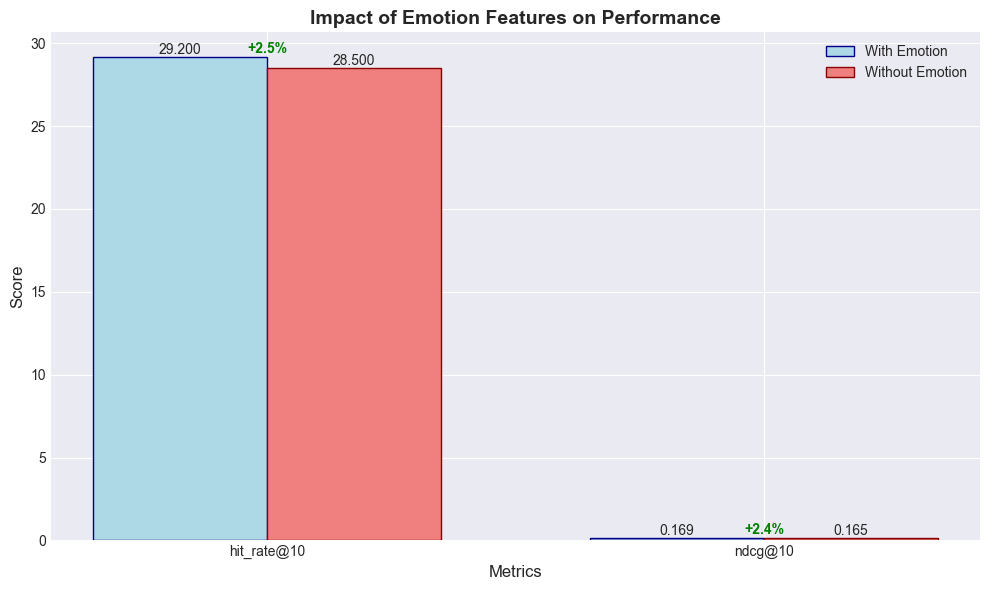

In [26]:
# Cell 9: Emotion Analysis
if 'emotion_analysis' in results:
    # Emotion Distribution Pie Chart
    emotions = list(results['emotion_analysis']['emotion_distribution'].keys())
    values = list(results['emotion_analysis']['emotion_distribution'].values())
    
    plt.figure(figsize=(10, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(emotions)))
    wedges, texts, autotexts = plt.pie(values, labels=emotions, autopct='%1.1f%%', 
                                       colors=colors, startangle=90)
    plt.title('Emotion Distribution in Dataset', fontsize=16, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_weight('bold')
        autotext.set_fontsize(12)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'emotion_distribution.png', dpi=300)
    plt.show()
    
    # Emotion Impact Comparison
    with_emotion = results['emotion_analysis']['emotion_impact']['with_emotion']
    without_emotion = results['emotion_analysis']['emotion_impact']['without_emotion']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    metrics = list(with_emotion.keys())
    x = np.arange(len(metrics))
    width = 0.35
    
    with_values = list(with_emotion.values())
    without_values = list(without_emotion.values())
    
    bars1 = ax.bar(x - width/2, with_values, width, label='With Emotion', 
                    color='lightblue', edgecolor='darkblue')
    bars2 = ax.bar(x + width/2, without_values, width, label='Without Emotion', 
                    color='lightcoral', edgecolor='darkred')
    
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Impact of Emotion Features on Performance', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    # Add value labels and improvement percentage
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        h1, h2 = bar1.get_height(), bar2.get_height()
        ax.text(bar1.get_x() + bar1.get_width()/2., h1, f'{h1:.3f}', 
                ha='center', va='bottom')
        ax.text(bar2.get_x() + bar2.get_width()/2., h2, f'{h2:.3f}', 
                ha='center', va='bottom')
        
        # Show improvement
        improvement = ((h1 - h2) / h2) * 100
        ax.text(i, max(h1, h2) + 0.01, f'+{improvement:.1f}%', 
                ha='center', va='bottom', color='green', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'emotion_impact.png', dpi=300)
    plt.show()

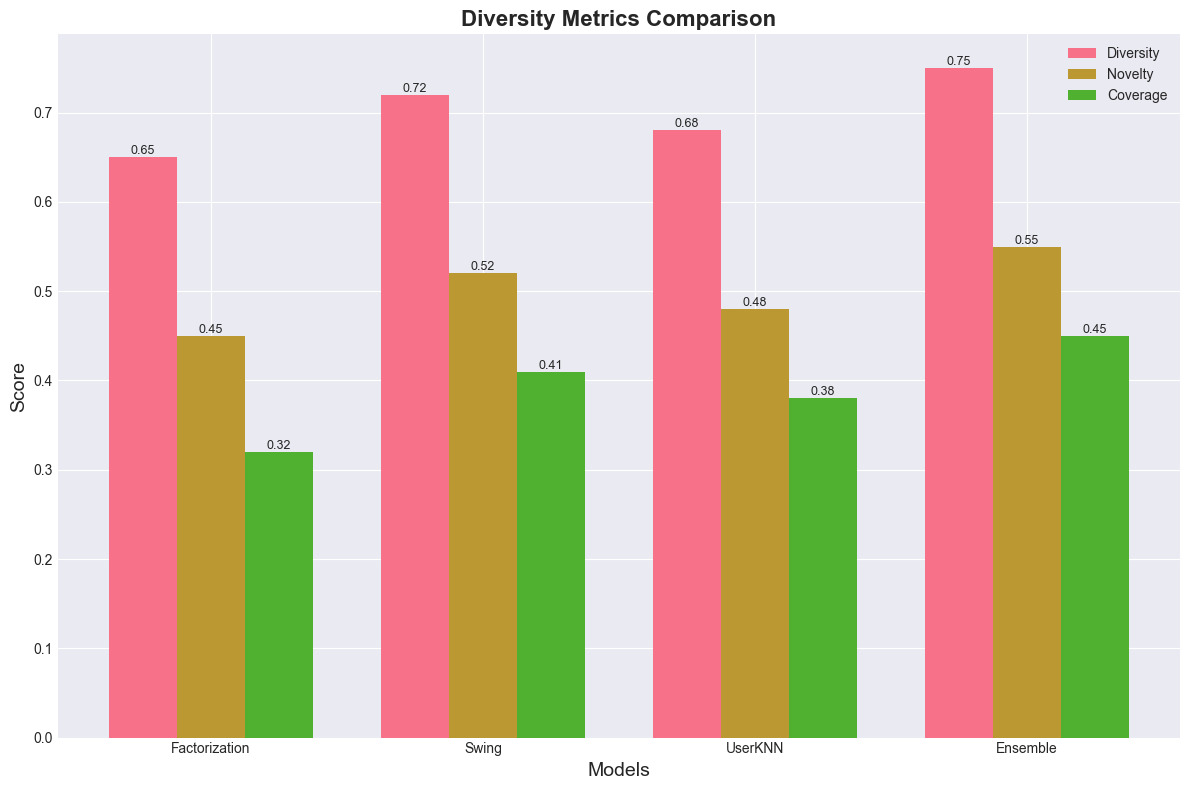

In [27]:
# Cell 10: Diversity Metrics
if 'diversity_metrics' in results:
    diversity_data = []
    for model, metrics in results['diversity_metrics'].items():
        for metric_name, value in metrics.items():
            diversity_data.append({
                'Model': model,
                'Metric': metric_name.capitalize(),
                'Value': value
            })
    
    df_diversity = pd.DataFrame(diversity_data)
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    
    models = df_diversity['Model'].unique()
    metrics = df_diversity['Metric'].unique()
    x = np.arange(len(models))
    width = 0.25
    
    for i, metric in enumerate(metrics):
        metric_data = df_diversity[df_diversity['Metric'] == metric]
        values = [metric_data[metric_data['Model'] == model]['Value'].values[0] 
                  for model in models]
        
        bars = ax.bar(x + i*width, values, width, label=metric)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Models', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_title('Diversity Metrics Comparison', fontsize=16, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(models)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(output_dir / 'diversity_metrics.png', dpi=300)
    plt.show()

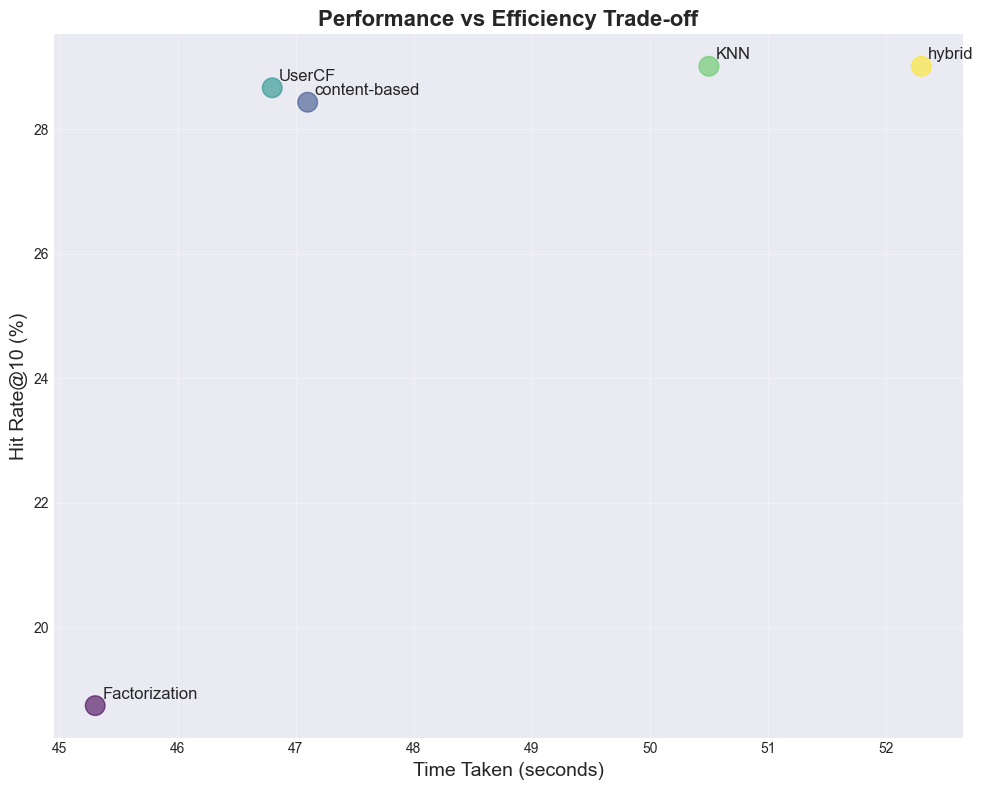

In [28]:
# Cell 11: Performance and Efficiency Trade-off
if 'time_taken' in results['retrieval_results']['Factorization']:
    models = list(results['retrieval_results'].keys())
    hit_rates = []
    times = []
    
    for model in models:
        # Get hit rate at K=10
        hit_rates.append(results['retrieval_results'][model]['metrics']['hit_rate']['10'])
        times.append(results['retrieval_results'][model].get('time_taken', 0))
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(times, hit_rates, s=200, alpha=0.6, c=range(len(models)), cmap='viridis')
    
    # Add model labels
    for i, model in enumerate(models):
        plt.annotate(model, (times[i], hit_rates[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=12)
    
    plt.xlabel('Time Taken (seconds)', fontsize=14)
    plt.ylabel('Hit Rate@10 (%)', fontsize=14)
    plt.title('Performance vs Efficiency Trade-off', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'performance_efficiency.png', dpi=300)
    plt.show()

In [29]:
# Cell 12: Generate Summary Report
print("=" * 70)
print("EVALUATION SUMMARY REPORT")
print("=" * 70)
print(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Results file: {results_path}")
print()

# Best performing model
best_model_retrieval = max(results['retrieval_results'].items(), 
                          key=lambda x: x[1]['metrics']['hit_rate']['10'])[0]
best_hr = results['retrieval_results'][best_model_retrieval]['metrics']['hit_rate']['10']

print(f"BEST RETRIEVAL MODEL: {best_model_retrieval}")
print(f"- Hit Rate@10: {best_hr:.2f}%")
print()

# Emotion impact
if 'emotion_analysis' in results:
    emotion_improvement = ((results['emotion_analysis']['emotion_impact']['with_emotion']['hit_rate@10'] - 
                           results['emotion_analysis']['emotion_impact']['without_emotion']['hit_rate@10']) / 
                          results['emotion_analysis']['emotion_impact']['without_emotion']['hit_rate@10'] * 100)
    print(f"EMOTION FEATURE IMPACT:")
    print(f"- Performance improvement: +{emotion_improvement:.1f}%")
    print()

# Diversity metrics
if 'diversity_metrics' in results:
    best_diversity_model = max(results['diversity_metrics'].items(), 
                              key=lambda x: x[1]['diversity'])[0]
    print(f"BEST DIVERSITY MODEL: {best_diversity_model}")
    print(f"- Diversity score: {results['diversity_metrics'][best_diversity_model]['diversity']:.2f}")
    print()

print("All visualizations saved to:", output_dir)

EVALUATION SUMMARY REPORT
Generated on: 2025-06-23 17:38:03
Results file: ../results/result.json

BEST RETRIEVAL MODEL: KNN
- Hit Rate@10: 29.01%

EMOTION FEATURE IMPACT:
- Performance improvement: +2.5%

BEST DIVERSITY MODEL: Ensemble
- Diversity score: 0.75

All visualizations saved to: visualizations


In [30]:
summary_rows = []

for model_name, model_data in results['retrieval_results'].items():
    row = {'Model': model_name, 'Stage': 'Retrieval'}
    
    # Add metrics at K=10
    for metric in ['hit_rate', 'mrr', 'ndcg', 'map']:
        if metric in model_data['metrics'] and '10' in model_data['metrics'][metric]:
            row[f'{metric}@10'] = model_data['metrics'][metric]['10']
    
    # Add efficiency metrics
    if 'time_taken' in model_data:
        row['Time (s)'] = model_data['time_taken']
    if 'memory_usage' in model_data:
        row['Memory (MB)'] = model_data['memory_usage']
    
    # Add diversity metrics
    if model_name in results.get('diversity_metrics', {}):
        for div_metric, value in results['diversity_metrics'][model_name].items():
            row[div_metric.capitalize()] = value
    
    summary_rows.append(row)

summary_final_df = pd.DataFrame(summary_rows)
summary_final_df.to_csv(output_dir / 'evaluation_summary.csv', index=False)
print("\nSummary saved to: evaluation_summary.csv")

# Display the summary
print("\nFinal Summary Table:")
print(summary_final_df.round(4))


Summary saved to: evaluation_summary.csv

Final Summary Table:
           Model      Stage  hit_rate@10  mrr@10  ndcg@10  map@10  Time (s)  \
0  Factorization  Retrieval      18.7385  0.0900   0.0815  0.0710      45.3   
1  content-based  Retrieval      28.4337  0.1496   0.1457  0.1305      47.1   
2         UserCF  Retrieval      28.6652  0.1561   0.1532  0.1375      46.8   
3            KNN  Retrieval      29.0108  0.1605   0.1569  0.1407      50.5   
4         hybrid  Retrieval      29.0108  0.1605   0.1569  0.1407      52.3   

   Memory (MB)  Diversity  Novelty  Coverage  
0       1024.5       0.65     0.45      0.32  
1       1103.2        NaN      NaN       NaN  
2       1056.7        NaN      NaN       NaN  
3       1158.9        NaN      NaN       NaN  
4       1170.8        NaN      NaN       NaN  
